# Máltækni - Náttúruvernd

# Data import & manipulation

In [ ]:
from numpy.random import default_rng
import time
import random
import re
import tqdm
import pandas as pd
import pickle
import numpy as np
import string
import matplotlib.pyplot as plt
from collections import defaultdict
import pprint
import json

from sklearn.model_selection import train_test_split

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim import models
from gensim import matutils
from gensim import similarities

import tokenizer
from islenska import Bin

from transformers import AutoModelForTokenClassification
from transformers import pipeline
from transformers import AutoTokenizer

In [ ]:
#@Vésteinn
def read_news_tsv(file_name):
    data = []
    with open(file_name, encoding="utf-8") as fh:
        for line in tqdm.tqdm(fh.readlines()):
            title, author, url, timestamp, _, _, text, text_tokenized = line.split("\t")
            article = {
                "title": title,
                "author": author,
                "timestamp": timestamp,
                "text": text,
                "text_tokenized": text_tokenized
            }
            data.append(article)
        return data

In [ ]:
articles = read_news_tsv("./data/icelandic_news_sample_22480.tsv")
print(f"Article count {len(articles)}")

In [ ]:
articles_df = pd.DataFrame(articles)

In [ ]:
articles_Big = read_news_tsv("./data/articles_until_01-11-2020_detok.tsv")
print(f"Article count {len(articles_Big)}")

In [ ]:
news_Big = pd.DataFrame(articles_Big)

In [ ]:
data_train, data_test = train_test_split(news_Big, test_size = 0.15, random_state=11)

In [ ]:
print(f'Training data examles: {data_train.shape[0]}')
print(f'Test data examles: {data_test.shape[0]}')

In [ ]:
data_test, data_test_labeled = train_test_split(data_test, test_size = 0.005, random_state=11)

In [ ]:
print(f'Test data examles: {data_test.shape[0]}')
print(f'Labeled test data examles: {data_test_labeled.shape[0]}')

In [ ]:
# Subset af training til að koma virkni í gang án þjálfunartíma
_, data_playground = train_test_split(data_train, test_size = 0.10, random_state=11)
print(f'Playground data examles: {data_playground.shape[0]}')

In [ ]:
timabil = pd.to_datetime(data_playground['timestamp'])

In [ ]:
timabil.sort_values()

# Skriftupælingar

In [ ]:
# Skoðar 'count' margar handahófskenndar fréttir og skilar lista af
# algildum indexum fyrir þær fréttir sem innihalda 'náttúruvernd', 'loftslag' eða 'umhverfi'
def rand_frett(safn, count):
    listi = []
    rng = default_rng()
    n = safn.shape[0]
    for i in tqdm.trange(count):
        x = rng.integers(n)
        if pd.isnull(safn.iloc[x]["text"]):
            continue
        frett = safn.iloc[x]["text"] # ath iloc
        frettnr = safn.iloc[x].name
        lykilord = ["náttúruvernd", "loftslag", "umhverfi"]
        fjoldi = 0
        for wrd in lykilord:
            fjoldi += len(re.findall(wrd, frett))
        if fjoldi > 0:
            listi.append(frettnr) # Ath. algildur index
            #print(frett)
    return listi

In [ ]:
# Skoðar allar fréttir í gefnu safni og skilar lista með algildum indexum 
# á þeim fréttum sem innihalda fleiri en 'threshold' fjölda af 'náttúruvernd', 'loftslag' eða 'umhverfi'
def allar_frettir(safn, threshold=0):
    listi = []

    n = safn.shape[0]
    for i in tqdm.trange(n):
        frett = safn.iloc[i]["text"]
        lykilord = ["náttúruvernd", "loftslag", "umhverfi"]
        fjoldi = 0
        for wrd in lykilord:
            fjoldi += len(re.findall(wrd, frett))
        if fjoldi > threshold:
            listi.append(i) # ath. afstæð númer m.v. safn
            #print(frett)
    return listi 

In [ ]:
# Athuga hvaða hlutfall kemur út úr síunni
sample_count = 100000
big_list = rand_frett(news_Big, sample_count)
print(len(big_list)/sample_count)

## Merkjum data_test_labeled

In [ ]:
sigtaðar_frettir = allar_frettir(data_test_labeled)

In [ ]:
for fr in sigtaðar_frettir[:3]:
    print(data_test_labeled.iloc[fr])

In [ ]:
len(sigtaðar_frettir)

In [ ]:
# for i in sigtaðar_frettir[:3]:
#     frett = data_test_labeled.iloc[i]
#     print(frett["text"])
#     print(frett["title"])
#     einkunn = input("Um náttúruvernd?\n")
#     if einkunn == str(1):
#         ja.append(frett.name)
#     elif einkunn == str(2):
#         vafi.append(frett.name)
#     else:
#         annad.append(frett.name)

In [ ]:
# Niðurstöður
jakvætt = {165133,322727,343386,233961,500609,327615}

# !! ATH breyta hér, flokka bara þau sem eru handyfirfarin sem neikvæð 
neikvætt = set(data_test_labeled.index).difference(jakvætt)

print(len(neikvætt))
print(len(jakvætt))
print(data_test_labeled.shape[0])

# data_test_labeled["label"] = np.zeros((len(data_test_labeled), 1), dtype = np.int8)
# for i in jakvætt:
#     data_test_labeled.loc[i,"label"] = 1
# for fr in big_list[:10]:
#     print(news_Big.loc[fr])

## Merkjum data_train

In [ ]:
# 'vistaðar niðurstöður' úr flokkun að neðan.
# jákvæðar fréttir úr train
ja =    {285192, 531728, 543888, 290583, 624031, 620326, 586792, 300335, 615601, 57271, 541114, 232512, 203202, 565829, 402387, 212309, 563685, 207852, 319984, 338039, 551033}
# fréttir sem eru kannski já, kannski ekki
vafi =  {188673, 253189, 582670, 549263, 580500, 196829, 138785, 201385, 146412, 624949, 467836, 18621}
# Neikvæðar fréttir sem komu úr síunni
annad = {425218, 398339, 232836, 377475, 40966, 108040, 61449, 411913, 441611, 188049, 594451, 357913, 389534, 447519, 403616, 598944, 403230, 438562, 383270, 300455, 260392, 545578, 245419, 496045, 280365, 111155, 77492, 616884, 26553, 598717, 397246, 264765, 180800, 353226, 292173, 217422, 53844, 179030, 306134, 524889, 622682, 288093, 557662, 146272, 471780, 628965, 111590, 180717, 506996, 129525, 423028, 19063, 409848, 290171}
# # Neikvæðar fréttir teknar af handahófi úr train
neinei = {41758, 45206, 94336, 122610, 133607, 152981, 190982, 210392, 235700, 258454, 276324, 294168, 303348, 328102, 333446, 344739, 351967, 356145, 376980, 426847, 429708, 437621, 460035, 461629, 524825, 566916, 581492, 612748, 631359, 631908}
possibly_corrupt = {628965, 409848, 549263}
print(ja, vafi, annad, sep="\n")
print(len(ja))

In [ ]:
def label(safn, sigti, count=-1):
    for nr, i in enumerate(sigti[:count]):
        if i in ja or i in vafi or i in annad:
            continue
        frett = safn.loc[i] # Gert er ráð fyrir global index
        print(f"Frétt nr. {nr}")
        print(frett["text"])
        print(frett["title"])
        einkunn = input("Um náttúruvernd?\n")
        print()
        if einkunn == str(1):
            ja.add(frett.name)
        elif einkunn == str(2):
            vafi.add(frett.name)
        elif einkunn == str(0):
            neinei.add(frett.name)
        else:
            annad.add(frett.name)

In [ ]:
# label(data_train, data_train.index)

Sigta af handahófi úr train <br>
Flokka sigtað í já og nei<br>
flokka af handahófi úr ósigtuðu (svo nei sé ekki bara sigtað nei)<br>
    - kannski í sér hóp til að sjá hvort það endurspeglist í flokkunum?<br>
Þegar það eru komnir nokkrir tugir í já, þá athuga hvar flokkaða lendir í LDA<br>
Kannski finna gögn sem eru sérstaklega um náttúruvernd, fréttir frá samtökum, Sólin, ...<br>

In [ ]:
slembsigti = rand_frett(data_train, 2000) # Hefði kannski átt að setja seed?

In [ ]:
# label(data_train, slembsigti)

In [ ]:
playground_sigti = allar_frettir(data_playground, 5)

In [ ]:
len(playground_sigti)

# GENSIM LDA pælingar

In [ ]:

stop_words = set()
extra_stop_words = ["var", "er", "ekki", "sé"]
with open("./data/is_stop_words.txt") as stop_word_file:
    for line in stop_word_file.readlines():
        stop_words.add(line.strip())
stop_words.update(set(string.punctuation))
stop_words.update(set(extra_stop_words))

In [ ]:
b = Bin()

def naive_bin_lemma(token):
    candidates = b.lookup_lemmas_and_cats(token)
    if not candidates:
        return None
    if len(candidates) > 1:
        return None
    cand = candidates.pop()
    if cand[1] not in ["kk", "kvk", "hk"]:
        return None
    return cand[0]


def tokenize_and_lemmatize(sentence):
    if pd.isnull(sentence): # Líklegast óþarft núna
            return []
    tokenized_text = list(tokenizer.split_into_sentences(sentence))
    lemmas = []
    for sent in tokenized_text:
        for token in sent.split():
            if token in stop_words:
                continue
            lemma = naive_bin_lemma(token.lower())
            if lemma is not None: # bæta við stop_words hér? and lemma not in stop_words
                lemmas.append(lemma)
    return lemmas

In [ ]:
def load_all():
    with open('./checkpoints/data_words.pickle', 'rb') as fh:
        data_words = pickle.load(fh)
    with open('./checkpoints/data_words_bigrams.pickle', 'rb') as fh:
        data_words_bigrams = pickle.load(fh)
    with open('./checkpoints/id2word.pickle', 'rb') as fh:
        id2word = pickle.load(fh)
    with open('./checkpoints/corpus.pickle', 'rb') as fh:
        corpus = pickle.load(fh)
    lda_model = gensim.models.ldamulticore.LdaModel.load("Big_lda_model")
    
    return data_words, data_words_bigrams, id2word, corpus, lda_model

In [ ]:
def build_all():
    data_words = [tokenize_and_lemmatize(a) for a in tqdm.notebook.tqdm(data_train["text_tokenized"])]

    # Build the bigram and trigram models
    bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
    trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

    # Faster way to get a sentence clubbed as a trigram/bigram
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)
    
    def make_bigrams(texts):
        return [bigram_mod[doc] for doc in texts]

    def make_trigrams(texts):
        return [trigram_mod[bigram_mod[doc]] for doc in texts]

    # See trigram example
    # print(trigram_mod[bigram_mod[data_words[0]]])
    data_words_bigrams = make_bigrams(tqdm.tqdm(data_words))
    # Create Dictionary
    id2word = corpora.Dictionary(data_words)

    # Create Corpus
    texts = data_words

    # Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts]
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                               id2word=id2word,
                                               num_topics=10, 
                                               random_state=100,
                                               update_every=1,
                                               chunksize=100,
                                               passes=10,
                                               alpha='auto',
                                               per_word_topics=True)

In [ ]:
def save_all():
    with open('./checkpoints/data_words.pickle', 'wb') as fh:
        pickle.dump(data_words, fh)
    with open('./checkpoints/data_words_bigrams.pickle', 'wb') as fh:
        pickle.dump(data_words_bigrams, fh)
    with open('./checkpoints/id2word.pickle', 'wb') as fh:
        pickle.dump(id2word, fh)
    with open('./checkpoints/corpus.pickle', 'wb') as fh:
        pickle.dump(corpus, fh)
    lda_model.save("./checkpoints/Big_lda_model")

In [ ]:
data_words, data_words_bigrams, id2word, corpus, lda_model = load_all()

In [437]:
len(id2word.keys())
#id2word.num_pos

320706

## Tilraunir

In [ ]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

In [ ]:
# Sjáum orðin tengd ákveðnum flokk
[id2word[i[0]] for i in lda_model.get_topic_terms(6, topn=50)]

In [ ]:
# Fáum hóp ákveðins orðs í safninu
# Af hverju sýnir þetta fyrir fæst orð?
lda_model.get_term_topics(id2word.token2id["króna"])

In [ ]:
sport = """„Úrslitin eru það mikilvægasta sem við tökum með okkur úr leik kvöldsins. Það er afrek að vinna Porto á útivelli. Að sigra eins og við sigruðum gerir sigurinn enn sætari,“ sagði Jürgen Klopp að loknum 5-1 sigri Liverpool á Drekavöllum í kvöld.
„Það var mikið af góðum augnablikum í leik kvöldsins. Við gátum séð að Porto horfði á leikinn okkar gegn Brentford þar sem þeir voru mjög beinskeyttir, ég vildi lagfæra það á vellinum og við gerðum það skref fyrir skref.“
"""
sport = tokenize_and_lemmatize(sport)

In [ ]:
covid= """Í gær greindust 36 einstaklingar innanlands með Covid-19 og voru 28 í sóttkví við greiningu. Tuttugu voru óbólusettir. 348 einstaklingar eru í einangrun hér á landi vegna sjúkdómsins og 1.164 í sóttkví. """
covid=tokenize_and_lemmatize(covid)

In [ ]:
def classify(text, verbose=False):
    bow_vector = id2word.doc2bow(text)
    #print(lda_model[bow_vector])
    for index, score in sorted(lda_model[bow_vector][0], key=lambda tup: -1*tup[1]):
        if verbose:
            print("Cluster: {}\t Score: {}\t Topic: {}".format(index, score, lda_model.print_topic(index, 5)))
    if verbose:
        print()
    return(lda_model[bow_vector][0])

In [ ]:
def lda_group(indexes, verbose=False):
    mat = np.zeros((len(indexes), 10), dtype=np.float32)
    for i, example in enumerate(tqdm.tqdm(indexes)):
        text = data_train.loc[example]["text_tokenized"] # getur verið news_Big fyrir öll dæmin
        lemm_text = tokenize_and_lemmatize(text)
        vec = classify(lemm_text)
        for group, score in vec:
            mat[i, group] = score
    score_sum = np.sum(mat, axis=0)
    if verbose:
        print(score_sum)
        prin3t(score_sum/sum(score_sum))
        print(-np.sort(-score_sum))
        print(np.argsort(-score_sum))
    return mat

In [ ]:
jalist = list(ja)

In [ ]:
ja_mat = lda_group(jalist, False)

In [ ]:
tops = np.argmax(ja_mat, axis=1)

In [ ]:
np.bincount(tops)

#top_d = dict()
#for item in tops:
#    count = tops.count(item)
#    top_d[item] = count

In [ ]:
# atta = [3,6,19,20]
# þristur = [8,12,15,16]
# sexa = [1,2,4,5,7,8,9,10,11,13,14,17]
# 
# for i in atta:
#     print(data_train.loc[jalist[i]]["title"])
# print()
# for i in þristur:
#     print(data_train.loc[jalist[i]]["title"])
# print()
# for i in sexa:
#     print(data_train.loc[jalist[i]]["title"])

In [ ]:
neineilist = list(neinei)
nei_mat = lda_group(neineilist)
np.argmax(nei_mat, axis=1)

In [ ]:
data_train.loc[neineilist[2]]

In [ ]:

def visual_groups(mat, save=None):
    vigur = np.sum(mat, axis=0)
    plt.bar(list(range(10)), vigur)
    plt.show()
    
    plt.bar(range(len(vigur)), -np.sort(-vigur))
    plt.xticks(range(len(vigur)), np.argsort(-vigur))
    if save:
        plt.savefig("./pics/"+save+"_summa.jpg")
    plt.show()

    
    tops = np.argmax(mat, axis=1)
    counts = np.bincount(tops)
    plt.bar(range(len(counts)), counts)
    plt.show()

    # raða
    plt.bar(range(len(counts)), -np.sort(-counts))
    plt.xticks(range(len(counts)), np.argsort(-counts))
    if save:
        plt.savefig("./pics/"+save+"_top.jpg")
    plt.show()

In [ ]:
visual_groups(lda_group(vafi, False), "vafi")

In [ ]:
# Keyrir í tæpar 40 mín, stallar á 95% að því er virðist að eilífu
# playground_groups = lda_group(data_playground.index, True)

In [ ]:
# Pælingar á ís.

# for j in data_test_labeled[data_test_labeled["label"] == 1]["text"]:
#     classify(tokenize_and_lemmatize(j))
#     print(j, "\n")
# 
# data_test_labeled[data_test_labeled["label"] == 0][:10]["text"]
# for nei in data_test_labeled[data_test_labeled["label"] == 0][:10]["text"]:
#     classify(tokenize_and_lemmatize(nei))
#     print(nei, "\n")
# for nei in data_test_labeled[data_test_labeled["label"] == 0][:10]:
#     print(nei)
#     texti = nei["text"]
#     print(nei["title"])
#     classify(tokenize_and_lemmatize(texti))
#     print(texti, "\n")

# TF IDF pælingar

In [ ]:
tfidf = models.TfidfModel(corpus) # sami corpus og fyrir LDA
corpus_tfidf = tfidf[corpus] # lazy

In [ ]:
lsi_200 = models.LsiModel.load("./checkpoints/lsi_model_200")
corpus_lsi_200 = lsi_200[corpus_tfidf] 

In [ ]:
lsi_500 = models.LsiModel.load("./checkpoints/lsi_model_500")
corpus_lsi_500 = lsi_500[corpus_tfidf] 

In [ ]:
load = True
if not load:
    t = time.time()
    lsi_model = models.LsiModel(corpus_tfidf, id2word=id2word, num_topics=200)  
    corpus_lsi = lsi_model[corpus_tfidf] 
    print(time.time() - t)

In [ ]:
data_train.loc[jalist[2]]["text"]
print(data_words[data_train.index.get_loc(2826)])


In [ ]:
topic_vector = ["friðland", "andrúmsloft", "umhverfissjónarmið", "loftslagsáhrif", "sjávarborð", "loftslagsvísindi", "ísöld", "náttúruhamfarir", "loftslagslíkan", "friðun", "loftslag-breyting", "umhverfisverndarsinni", "losun", "heildarlosun", "kol", "umhverfisverndarstofa", "umhverfisdómstóll", "auðlindaráðuneyti", "loftslagsstefna", "orkunotkun", "umhverfisskattur", "aðgerðasinni", "hamfarahlýnun", "skref", "útlosun", "lifnaðarháttur", "náttúruauðlind", "náttúruverndarlög", "umhverfisfræði", "orkugjafi", "loftslagsmál", "landnotkun", "úrgangur", "sóun", "útblástur", "gráðurhúsaáhrif", "stóriðja", "kolefnishlutleysi", "umhverfisþing", "umhverfisáhrif", "loftslagsbreyting", "súrnun", "sjór", "vistkerfi", "hringrásarhagkerfi", "sjálfbærni", "parísarsamkomulag", "gróðurhúsalofttegund", "loftslagsaðgerðir", "loftslagsvá", "náttúruvernd", "loftslag", "umhverfi", "náttúra", "hlýnun", "jörð", "loftslagsráðstefna", "þjóðgarður", "bráðna", "jökull", "umhverfisvernd", "mengun", "jarðefnaeldsneyti", "náttúruverðmæti"]
topic_vector.sort()
t = lsi_500[tfidf[id2word.doc2bow(topic_vector)]]
a = corpus_lsi_500[300]
# sama og 
# a = lsi_model[tfidf[corpus[300]]]
matutils.cossim(a, t)

In [ ]:
lsi_200.print_topics(10)

In [ ]:
#import logging
#logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
#logging.disable()


In [ ]:
#for doc, as_text in zip(corpus_lsi, data_train["text"][:55000]):
#    print(doc, as_text)
#

In [ ]:
maxs, maxi = (-1,-1)
nbr = 10000
score_matrix = np.zeros((1,nbr))
for i in range(nbr):
    a = lsi_200[tfidf[corpus[i]]]
    sim = matutils.cossim(a,t)
    score_matrix[0, i] = sim
    if sim > maxs:
        maxs = sim
        maxi = i
print(maxs, maxi)

In [ ]:
plt.scatter(range(nbr), np.sort(score_matrix))
plt.title("LSI scores")
plt.xlabel("Number of articles")
plt.ylabel("Score")
plt.plot([0, 10000], [0.15, 0.15],color='green',
         linestyle='dashed',linewidth=2)
plt.savefig("./pics/LSI.jpeg")
plt.show()

In [ ]:
start = time.time()
included = list()
for i in range(len(corpus)):
    a = lsi_200[tfidf[corpus[i]]]
    sim = matutils.cossim(a,t)
    if sim > 0.15:
        included.append(i)
        #print(data_train.iloc[i]["title"])
print(time.time()-start)

In [ ]:
len(included)

In [ ]:
with open("./checkpoints/included015.json", "w") as fh:
    fh.write(json.dumps(included))

In [ ]:
for i in random.sample(included, k=10):
    print(data_train.iloc[i]["title"])

In [ ]:
for i in jalist:
    a = corpus_lsi_200[data_train.index.get_loc(i)]
    sim = matutils.cossim(a,t)
    if sim>0.15:
        print(sim, data_train.loc[i]["title"])

In [ ]:
data_train.loc[jalist[8]]["title"]

In [ ]:
index = similarities.SparseMatrixSimilarity(tfidf[corpus], num_features=12)


In [ ]:
query_document = topic_vector


In [ ]:
query_bow = id2word.doc2bow(query_document)


In [ ]:
# Krassar

# sims = index[tfidf[query_bow]]
# index.get_similarities(tfidf[id2word.doc2bow(topic_vector)])


In [ ]:
print(list(enumerate(sims)))

# NER

In [ ]:
modelX = AutoModelForTokenClassification.from_pretrained("eliasbe/XLMR-ENIS-finetuned-ner")
tokenizerX = AutoTokenizer.from_pretrained("eliasbe/XLMR-ENIS-finetuned-ner", model_max_length=512)
xlmr = pipeline("ner", model=modelX, tokenizer=tokenizerX)

In [ ]:
# Bypass for maximum length of xlmr model
def ner(text):
    length = len(text)
    half = length//2
    try:
        return xlmr(text)
    except:
        return ner(text[:half]) + ner(text[half:])

In [ ]:
# Athuga að við viljum væntanlega halda utan um staðsetningu líka síðar

# Fall sem nær í nöfn úr texta
def get_names(text):
    l = list()
    end = -1
    beg = False
    for entry in ner(text):
        if entry['entity'] in {'B-Person', 'I-Person'}:                               
            word = entry['word'].strip() 
            if word in set(string.punctuation):
                end = int(entry['end'])
                continue
            if word[0] == '▁':
                word = word[1:]
                beg = True
            if end == int(entry['start']) and l:
                last = l[-1]
                if beg:
                    nxt = " ".join([last, word])
                else:
                    nxt = "".join([last, word])
                l = l[:-1]
                l.append(nxt)
            else:
                l.append(word)
            end = int(entry['end'])
        beg = False
    l = set(l)
    return l
            

In [ ]:
# Convert a single name to nefnifall
def nefnifall_stk(nafn):
    out = list()
    temp = list()
    cats = list()
    nöfn = nafn.split()

    # Athuga ef nöfnin hafa mörg kyn, kjósa um það
    for n in nöfn:
        kyn = list(b.lookup_cats(n))
        for k in kyn:
            cats.append(k)
    if len(set(cats)) > 1:
        k = max(set(cats), key=cats.count)
    elif cats:
        k = cats[0]
    #print(k)

    # Setja nefnifallið í lista
    for n in nöfn:   
        try: # Fyrir erlend nöfn
            variant = b.lookup_variants(n, k, ("NF", "ET"))
        except:
            variant = None
        #print(variant)
        if variant: 
            if len(variant) > 1: # Ef til eru margar útfærslur á nafninu (Þór/Þórr) 
                same = False
                for v in variant:
                    if v.bmynd == n:
                        temp.append(n)
                        same = True
                        break
                    vb = v.bmynd
                if not same:
                    temp.append(vb)
            else:                    
                temp.append(variant[0].bmynd)
        else:
            temp.append(n)
    name_nf =" ".join(temp)
    return name_nf

# Convert a list of names to nf.
def nefnifall(nafnalisti):
    out = list()
    for nafn in nafnalisti:
        out.append(nefnifall_stk(nafn))
    return out

In [ ]:
# Orðabók til að einræða flokka og sía út

flokkamap = {'Alþýðubandalag': 'Alþýðubandalagið',
 'Alþýðubandalagið': 'Alþýðubandalagið',
 'Alþýðuflokkur': 'Alþýðuflokkurinn',
 'Alþýðuflokkurinn': 'Alþýðuflokkurinn',
 'Borgaraflokkur': 'Borgaraflokkurinn',
 'Borgaraflokkurinn': 'Borgaraflokkurinn',
 'Borgarahreyfingin': 'Borgarahreyfingin',
 'Bændaflokkur': 'Bændaflokkurinn',
 'Flokkur fólksins': 'Flokkur fólksins',
 'Bændaflokkurinn': 'Bændaflokkurinn',
 'Framfaraflokkurinn': 'Framfaraflokkurinn',
 'Framsóknar': 'Framsóknarflokkurinn',
 'Framsóknarflokkur': 'Framsóknarflokkurinn',
 'Framsóknarflokkurinn': 'Framsóknarflokkurinn',
 'Frjálslyndi': 'Frjálslyndi',
 'Heimastjórnarflokkur': 'Heimastjórnarflokkurinn',
 'Heimastjórnarflokkurinn': 'Heimastjórnarflokkurinn',
 'Kommúnistaflokkurinn': 'Kommúnistaflokkurinn',
 'Landvarnarflokkurinn': 'Landvarnarflokkurinn',
 'Miðflokkurinn': 'Miðflokkurinn',
 'Píratar': 'Píratar',
 'Sambandsflokkurinn': 'Sambandsflokkurinn',
 'Sameiningarflokkur': 'Sameiningarflokkur',
 'Samfylkingin': 'Samfylkingin',
 'Sjálfstæðisflokkur': 'Sjálfstæðisflokkurinn',
 'Sjálfstæðisflokkurinn': 'Sjálfstæðisflokkurinn',
 'Sparnaðarbandalagið': 'Sparnaðarbandalagið',
 'Sósíalistaflokkur': 'Sósíalistaflokkurinn',
 'Sósíalistaflokkurinn': 'Sósíalistaflokkurinn',
 'Utanflokkabandalagið': 'Utanflokkabandalagið',
 'Vinstrihreyfingin': 'VG',
 'Vinstrihreyfingin - grænt framboð': 'VG',
 'Viðreisn': 'Viðreisn',
 'Íhaldsflokkurinn': 'Íhaldsflokkurinn',
 'Þjóðræðisflokkurinn': 'Þjóðræðisflokkurinn',
 'Þjóðvaki': 'Þjóðvaki',
 'Þjóðvarnarflokkurinn': 'Þjóðvarnarflokkurinn',
 'Kvennalistinn': 'Kvennalistinn',
 'vennalistinn': 'Kvennalistinn',
 'reisn': 'Viðreisn',
 'Björt framtíð': 'Björt framtíð', 
 'Björt': 'Björt framtíð',
 'Samtök um kvennalista': 'Samtök um kvennalista',
 'Samtök um jafnrétti og félagshyggju': 'Samtök um jafnrétti og félagshyggju',
 'þingflokkur jafnaðarmanna': 'þingflokkur jafnaðarmanna',
 'Samtök frjálslyndra og vinstri manna': 'Samtök frjálslyndra og vinstri manna',
 'Framfaraflokkur': 'Framfaraflokkurinn',
 'Framfaraflokkurinn': 'Framfaraflokkurinn', 
 'Bandalag jafnaðarmanna': 'Bandalag jafnaðarmanna',
 'ramsóknarflokkur': 'Framsóknarflokkurinn'             
}

In [ ]:
# Fall til að sækja flokk úr texta, sér í lagi 'Alþingismenn.txt'

def get_party(text):
    l = list()
    end = -1
    beg = False
    for entry in ner(text):
        if entry['entity'] == 'B-Organization':                               
            word = entry['word']
            if word in set(string.punctuation):
                end = int(entry['end'])
                continue
            if word[0] == '▁':
                word = word[1:]
                beg = True
            if word[0] in set(string.punctuation):
                word = word[1:]
            if end == int(entry['start']):
                last = l[-1]
                if beg:
                    nxt = " ".join([last, word])
                else:
                    nxt = "".join([last, word])
                l = l[:-1]
                l.append(nxt)
            else:
                l.append(word) # Athuga með að sía fyrir raunverulegum flokkum
            end = int(entry['end'])
        beg = False
    out = set()
    for flokk in l:
        if flokk in flokkamap:
            out.add(flokkamap[flokk])
        #else:
        #    print("Party not found: ", flokk)
    
    # Bara fyrir alþingismannatalið
    if not out:
        party = re.findall("\(((?:\w|\s)*)\)\.", text)
        for p in party:
            if p in flokkamap:
                out.add(flokkamap[p]) # ath, var flokk í stað p
            #else:
            #    print(p)
    return out
            

In [ ]:
# https://www.althingi.is/altext/cv/is/
with open("./data/Alþingismenn.txt", "r") as f:
    alþingi = f.readlines()

In [447]:
# Smíðar skrá sem geymir Nafn:flokkur fyrir alla fyrri alþingismenn

member_party = dict()
for sentence in alþingi:
    
    # ML methods
    member = get_names(sentence)
    party = get_party(sentence)

    
    #print(member, party)
    for m in member:  
        if m in member_party:
            member_party[m] = member_party[m].union(party)
        else:
            member_party[m] = party

In [329]:
re_member_party = dict()
for sentence in alþingi:
    
    member = re.findall("^\s*((?:\w|\s)*)\.", sentence)
    party = re.findall("\(((?:\w|\s)*)\)\.", sentence)
    
    p_list = list()
    for p in party:
        if p in flokkamap:
            p_list.append(flokkamap[p])
    party = set(p_list)
    
    #print(member, party)
    
    if member:
        if member[0] not in re_member_party:
            re_member_party[member[0]] = set(party)
        else:
            re_member_party[member[0]] = re_member_party[member[0]].union(set(party))
    else:
        print(sentence)

In [490]:
with open("./checkpoints/re_member_party.pickle", "wb") as fh:
    pickle.dump(re_member_party, fh) 
with open("./checkpoints/member_party.pickle", "wb") as fh:
    pickle.dump(member_party, fh) 

In [ ]:
flokkar = set()
for it in member_party.values():
    for i in it:
        flokkar.add(i)

In [ ]:
flokkar

In [ ]:
oflokkadir = list()
flokkadir = list()
ath_linur = list()
for idx, key in enumerate(member_party):
    if not member_party[key]:
        oflokkadir.append(key)
        ath_linur.append(idx)
    else:
        flokkadir.append(key)

In [ ]:
len(oflokkadir)/(len(flokkadir)+len(oflokkadir))

In [ ]:
len(oflokkadir) + len(flokkadir)

In [ ]:
#for lina in range(len(ath_linur)):
#    print(alþingi[ath_linur[lina]], oflokkadir[lina], sep=" ")

In [ ]:
with open("./data/Current_alþingismenn.txt", "r") as f:
    current_alþingi = f.readlines()

current_member_party = dict()
for line in current_alþingi:
    line = line.strip()
    line = line.split("   ")
    current_member_party[line[0]] = flokkamap[line[1]]
    

In [ ]:
current_member_party

In [ ]:
current_flokkar = set()
for it in current_member_party.values():
    current_flokkar.add(it)

In [ ]:
current_flokkar

In [ ]:
def get_names_pos(text):
    l = defaultdict(list)
    temp_name = ''
    temp_pos = tuple()
    end = -1
    beginning = False
    temp = False
    
    for entry in ner(text):
        if entry['entity'] in {'B-Person', 'I-Person'}:                               
            
            word = entry['word'].strip() 
            if word in set(string.punctuation):
                end = int(entry['end'])
                if temp:
                    temp_pos = (temp_pos[0], end)
                continue
            
            if word[0] == '▁':
                word = word[1:]
                beginning = True
                
                
            if end == int(entry['start']):
                if beginning and temp:
                    temp_name = temp_name + ' ' + word
                else:
                    temp_name = temp_name + word
                
                if temp:    
                    temp_pos = (temp_pos[0], int(entry['end']))
                else:
                    temp_pos = (int(entry['start']), int(entry['end']))
            
            else:
                if temp:
                    l[temp_name].append(temp_pos)
                temp_name = word
                temp_pos = (int(entry['start']), int(entry['end']))
                temp = True
                
            end = int(entry['end'])
            
        beginning = False
    if temp:
        l[temp_name].append(temp_pos)   


    return l
            

In [ ]:
bla = get_names_pos(data_train.loc[543889]["text"])
bla.items()

In [ ]:
def statistics_table(text, idx, member_party_dict, member_stats, idx_stats):
    member_pos = dict()
    names_pos = get_names_pos(text)
    parliamenterian = False
    for nafn, pos in names_pos.items():
        nafn_nf = nefnifall_stk(nafn)
#         print(nafn_nf)
        if nafn_nf in member_party_dict:
            member_stats[nafn_nf].add(idx)
            member_pos[nafn_nf] = pos
            
            parliamenterian = True

    if parliamenterian:
        # idx_stats[idx] = member_pos
        entry = {
            "idx": idx,
            "pos": member_pos
        }
        idx_stats.append(entry)
        
        
    return member_stats, idx_stats

In [ ]:
member_stats = defaultdict(set)
idx_stats = list()

In [319]:
for i in tqdm.trange(4000, 7000):
    frett = data_train.iloc[i]
    member_stats, idx_stats = statistics_table(frett["text"], frett.name, current_member_party, member_stats, idx_stats)

100%|██████████| 3000/3000 [30:32<00:00,  1.64it/s] 


In [320]:
with open('./checkpoints/member_stats.pickle', 'wb') as fh:
    pickle.dump(member_stats, fh)
with open('./checkpoints/idx_stats.pickle', 'wb') as fh:
    pickle.dump(idx_stats, fh)

In [ ]:
incl_member_stats = defaultdict(set)
incl_idx_stats = list()

In [305]:
for i in tqdm.tqdm(included):
    frett = data_train.iloc[i]
    incl_member_stats, incl_idx_stats = statistics_table(frett["text"], frett.name, current_member_party, incl_member_stats, incl_idx_stats)

100%|██████████| 4145/4145 [1:01:07<00:00,  1.13it/s]


In [317]:
with open('./checkpoints/incl_member_stats.pickle', 'wb') as fh:
    pickle.dump(incl_member_stats, fh)
with open('./checkpoints/incl_idx_stats.pickle', 'wb') as fh:
    pickle.dump(incl_idx_stats, fh)

In [309]:
def mem_to_pd(member_stats, member_party):
    temp_list = []
    for member, mengi in member_stats.items():
        entry = {
            "member": member,
            "articles": mengi
        }
        temp_list.append(entry)
        
    mem_stat = pd.DataFrame(temp_list)
    mem_stat["count"] = mem_stat.apply(lambda row: len(row.articles), axis=1)
    mem_stat["party"] = mem_stat.apply(lambda row: member_party[row.member], axis=1)
    
    return mem_stat
    
def id_to_pd(idx_stats):
    temp_list = []
        
    id_stat = pd.DataFrame(idx_stats)
    id_stat["time"] = pd.to_datetime(id_stat.apply(lambda row: data_train.loc[row.idx]["timestamp"], axis=1))
    id_stat["author"] =id_stat.apply(lambda row: data_train.loc[row.idx]["author"], axis=1)
    
    return id_stat

In [311]:
incl_mem_stat = mem_to_pd(incl_member_stats, current_member_party)
incl_id_stat = id_to_pd(incl_idx_stats)

# Tölfræði

In [460]:
def plot_flokk(bok, save=None, color=False):
    if color:
        colors = list()
        for key in bok.keys():
            colors.append(party_color[key])
        bars = plt.bar(bok.keys(), bok.values(), color=colors)
    else:
        bars = plt.bar(bok.keys(), bok.values())
    #print(bars.label)
    plt.xticks(rotation=90)
    plt.title("Number of article appearances of parliamentarians by party")
    plt.xlabel("Party")
    plt.ylabel("Count")
    if save:
        plt.savefig("./pics/" + save + ".jpeg", bbox_inches="tight")
    plt.show()

In [399]:
party_color = {'VG': 'green',
               'Sjálfstæðisflokkurinn': 'blue',
               'Píratar': 'purple',
               'Viðreisn': 'orange',
               'Samfylkingin': 'red', 
               'Miðflokkurinn': 'blue',
               'Framsóknarflokkurinn': 'green', 
               'Flokkur fólksins': 'yellow'
              }

In [400]:
def plot_member(bok, save=None):
    plt.figure(figsize=(6, 10))
    plt.barh(list(bok.keys()), bok.values())
    plt.title("Fjöldi fréttabirtinga alþingismanna")
    plt.title("Number of parliamentarian's article appearances")
    plt.xlabel("Count")
    plt.ylabel("parliamentarian")
    if save:
        plt.savefig("./pics/" + save + ".jpeg", bbox_inches="tight")
    plt.show()
    
    # plt.barh(list(range(len(bok.keys()))), bok.values())
    # 
    # plt.ylabel(list(bok.keys()))
    # plt.yticks(rotation=90)
    # plt.show()

#### nýja 

In [401]:
def top_parliamentarians(df, threshold, title=None, save=None):
    df.sort_values(by=['count'], inplace=True)
    df[df["count"]>threshold].plot.barh(x="member", y="count")
    plt.ylabel("parliamentarian")
    if title:
        plt.title(title)
    if save:
        plt.savefig(f"./pics/{save}.jpeg")
    plt.show()

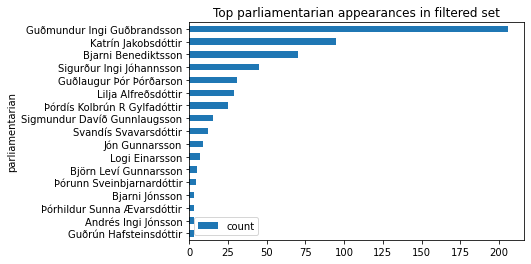

In [402]:
top_parliamentarians(incl_mem_stat, 2, title="Top parliamentarian appearances in filtered set", save="filtered_parliamentarians")

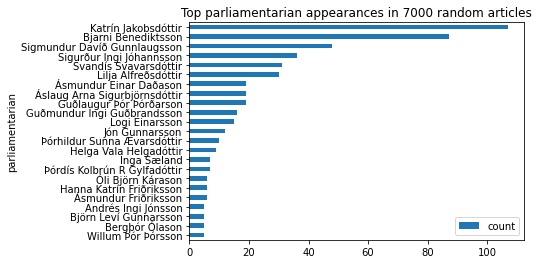

In [403]:
top_parliamentarians(mem_stat, 4, title="Top parliamentarian appearances in 7000 random articles", save="7000_parliamentarians")

In [479]:
def top_flokk(df, save=None, color=False):
    flokkar_count = defaultdict(int)
    for i in df.index:
        parties = df.loc[i]["party"]
        if isinstance(parties, str):
            flokkar_count[parties] += df.loc[i]["count"]
        else:
            for p in parties:
                flokkar_count[p] += df.loc[i]["count"]
        
    flokkar_count = sort_dict(flokkar_count)
    
    plot_flokk(flokkar_count, save, color)

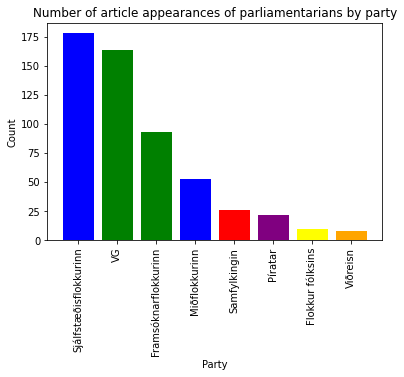

In [480]:
top_flokk(mem_stat, "7000_parties.jpeg", color=True)

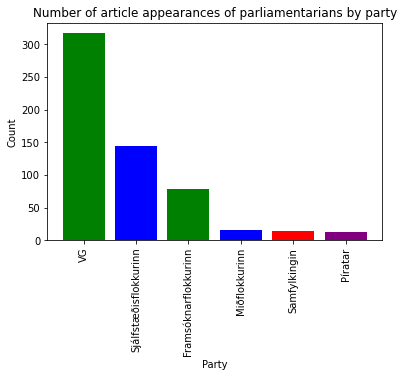

In [481]:
top_flokk(incl_mem_stat, "incl_parties.jpeg", color=True)

In [423]:
def plot_year(df, year, name, filt=None):
    dfyear = df[np.logical_and(df["time"] > pd.to_datetime(f"{year-1}/12/31 23:59"), df["time"] < pd.to_datetime(f"{year + 1}/01/01 00:00"))]

    year_members = defaultdict(int)
    for i in dfyear.index:
        for key in dfyear.loc[i]["pos"].keys():
            year_members[key] += 1
            
    year_members = sort_dict(year_members)

    # plt.barh(list(year_members.keys()), list(year_members.values()))
    
    year_df = pd.DataFrame.from_dict(year_members, orient='index', columns=['count'])
    if filt:
        year_df = year_df[year_df["count"] > filt]
    year_df.plot.barh()
    plt.xlabel("Number of articles")
    plt.ylabel("parliamentarian")
    plt.title(f"parliamentarian appearances in {name} articles from {year}")
    plt.savefig(f"./pics/{name}_parliamenterians_{year}.jpeg")
    plt.show()
    
    # flokkar_count = defaultdict(int)
    # for i in dfyear.index:
    #     flokkar_count[dfyear.loc[i]["party"]] += dfyear.loc[i]["count"]
    # 
    # plot_flokk(flokkar_count)


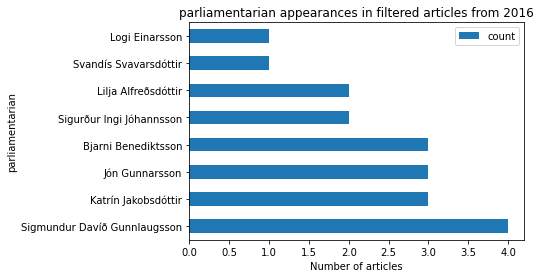

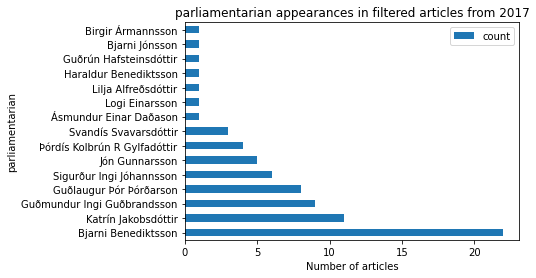

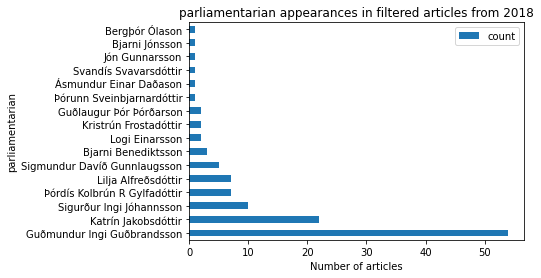

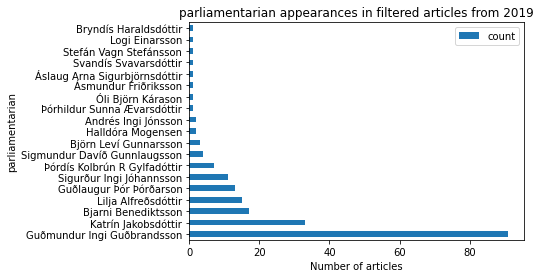

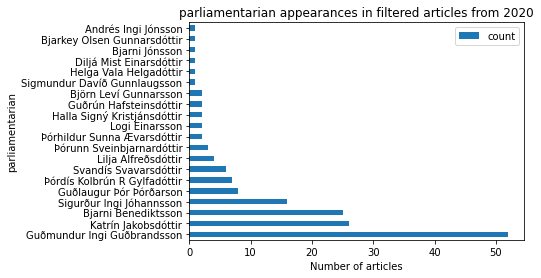

In [421]:
for year in range(2016, 2021):
    plot_year(incl_id_stat, year, "filtered")

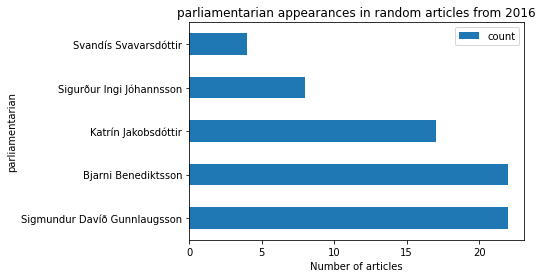

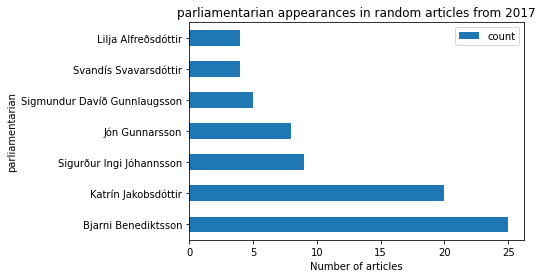

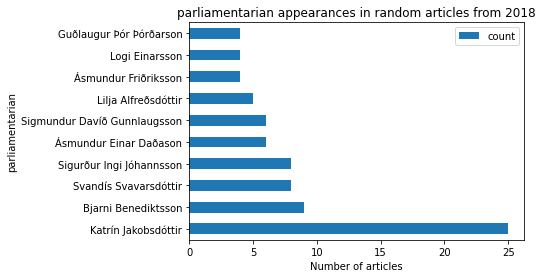

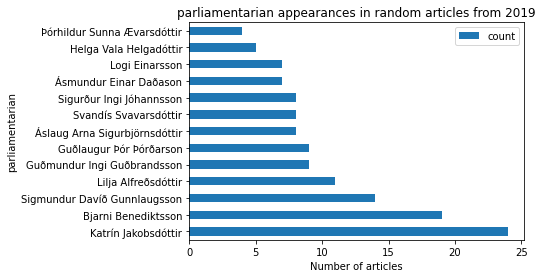

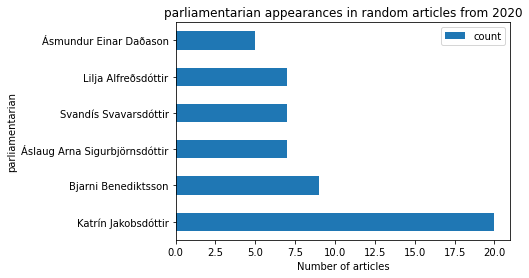

In [424]:
for year in range(2016, 2021):
    plot_year(id_stat, year, "random", 3) #7000

In [440]:
with open("inc_all_idx_stats.pickle", "rb") as fh:
          inc_all_idx_stats = pickle.load(fh)
with open("inc_all_member_stats.pickle", "rb") as fh:
          inc_all_member_stats = pickle.load(fh)

In [448]:
inc_all_member_stats = mem_to_pd(inc_all_member_stats, member_party)
inc_all_idx_stats = id_to_pd(inc_all_idx_stats)

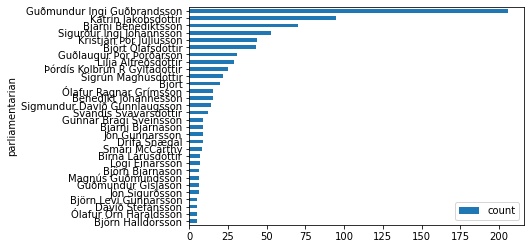

In [450]:
top_parliamentarians(inc_all_member_stats, 4)

In [ ]:
 # !! ATH 'BJÖRT'

In [456]:
inc_all_member_stats["party"] = inc_all_member_stats.apply(lambda row: list(row.party)[0], axis=1)

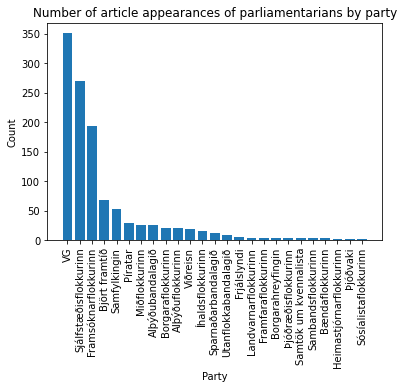

In [482]:
top_flokk(inc_all_member_stats)

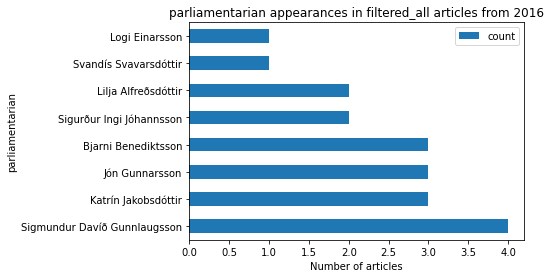

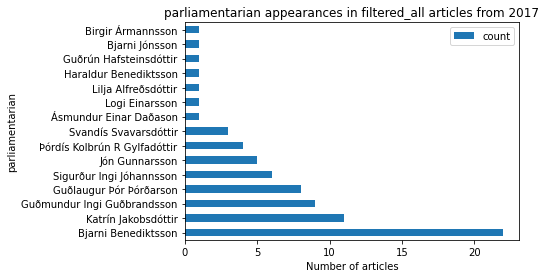

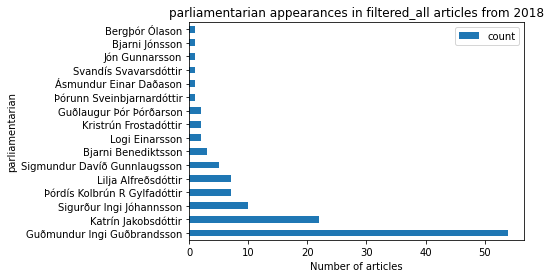

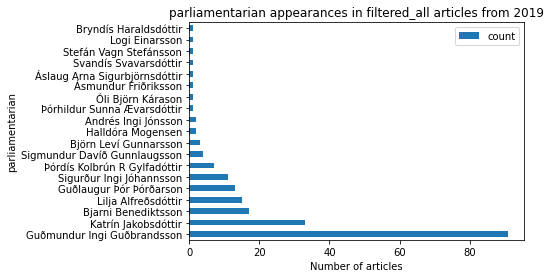

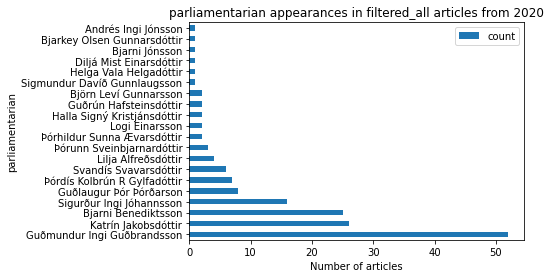

In [486]:
for year in range(2016, 2021):
    plot_year(incl_id_stat, year, name="filtered_all")

#### gamla

In [ ]:
plot_flokk(sort_dict(current_party_hits), "flokkar")

In [ ]:
plot_member(sort_dict(current_member_hits), "alþingismenn")

Flokka stóran flokk eins og playground
Gera tölfræðina skiljanlega og fallega

Halda utan um hvaða greinar innihalda alþingismenn
Ath hvort við getum flokkað topic eitthvað í þeim greinum

Gera glærur
Æfa fyrirlestur



## Gamla tölfræðin

In [ ]:
# Detect names/parties mentioned article, update count-dictionaries for each
# Before: text = article text, 
#         member_party_dict = dictionary in the format member : party
#         member_hits, party_hits: counter dictionaries in the format of
#              member of alþingi : number of "hits" or articles mentioning member
#              political party : num of articles mentioning party
# After: Returns updated counters

def count_hits(text, member_party_dict, member_hits, party_hits):
    names = get_names(text)
    for nafn in names:
        nafn_nf = nefnifall_stk(nafn)
#         print(nafn_nf)
        if nafn_nf in member_party_dict:
            flokkur = member_party_dict[nafn_nf] # this should already be declined in nf.
            if nafn_nf in member_hits:
                member_hits[nafn_nf] += 1
            else: member_hits[nafn_nf] = 1
            if flokkur in party_hits:
                party_hits[flokkur] += 1
            else: party_hits[flokkur] = 1    
    return member_hits, party_hits


# Initialize the hit counters
member_hits = dict()
party_hits = dict()

# Test on a the "Þórr" article
text_tmp = data_train.loc[543888]["text"]
member_hits, party_hits = count_hits(text_tmp, current_member_party, member_hits, party_hits)

print(member_hits)
print(party_hits)

In [ ]:
def sort_dict(d):
    # Sort dictionary by value
    marklist=sorted((value, key) for (key,value) in d.items())
    marklist.reverse()
    sortdict=dict([(k,v) for v,k in marklist])
    return sortdict

In [ ]:
# Start new counters for current alþingismenn/flokkar
# current_member_hits = dict()
# current_party_hits = dict()


# Count current members and parties mentioned in a list environmentally-centered news (jálist)
for i in tqdm.tqdm(jalist):
    art_text = data_train.loc[i]["text"]
    current_member_hits, current_party_hits = count_hits(art_text, current_member_party, current_member_hits, current_party_hits)
    
print(current_member_hits)
print(current_party_hits)



In [ ]:
print(sort_dict(current_member_hits))
print(sort_dict(current_party_hits))

In [ ]:
# Start new counters for current alþingismenn/flokkar
current_member_hits = dict()
current_party_hits = dict()
for fl in current_flokkar:
    current_party_hits[fl] = 0


# Count current members and parties mentioned in a list environmentally-centered news (jálist)
for i in tqdm.tqdm(list(ja)):
    art_text = data_train.loc[i]["text"]
    current_member_hits, current_party_hits = count_hits(art_text, current_member_party, current_member_hits, current_party_hits)
    
print(sort_dict(current_member_hits))
print(sort_dict(current_party_hits))

In [ ]:
current_party_hits = dict()
for fl in current_flokkar:
    current_party_hits[fl] = 0

In [ ]:
for i in tqdm.trange(2000,4000):
    art_text = data_playground.iloc[i]["text"]
    #print(data_playground.iloc[i]["title"])
    current_member_hits, current_party_hits = count_hits(art_text, current_member_party, current_member_hits, current_party_hits)
    
print(sort_dict(current_member_hits))
print(sort_dict(current_party_hits))

In [ ]:
with open("current_member_hits.json", "w") as fh:
    fh.write(json.dumps(current_member_hits))
with open("current_party_hits.json", "w") as fh:
    fh.write(json.dumps(current_party_hits))